# EEG Data interpretation -  Meditation and Individual Alpha Frequency (iAF)

This notebook processes EEG data of subjects that participated in the following experimental protocol:

Baseline blocks
	1.	Eyes Open (EO) – 2 minutes
	2.	Eyes Closed (EC) – 2 minutes

Task blocks
	3.	No music + finger tapping – 2 minutes
	4.	Break – 1 minute
	5.	Music (rock or classical) + finger tapping – 2 minutes
	6.	Break – 1 minute

Meditation
	7.	Meditation – 10 minutes

Post-meditation baseline
	8.	Eyes Closed (EC) – 2 minutes

The scope of the experiment is to compare the changes in alpha and theta frequencies, and their ratio (iAF) across the baseline, meditation, and post meditation, between-subjects. 

## Preprocessing Pipeline:
1. Notch filtering (50, 100 Hz) - Remove line noise
2. Bandpass filtering (1-40 Hz) - Keep relevant frequency bands
3. ICA - Remove artifacts (eye blinks, muscle activity)
4. Epoching - Segment data around events (TODO)
5. Power analysis - Extract alpha/theta power (TODO)


## 1. Import Libraries and Setup


In [115]:
import mne
import pandas as pd
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from pathlib import Path

# inline plotting
%matplotlib inline

# get the directory where this notebook is located
script_dir = Path.cwd()

## 2. Load EEG Data


In [116]:
raw_data = mne.io.read_raw_brainvision(
        script_dir / "data/classical_A_M_2025-12-15_15-04-18.vhdr",
        preload=True
    )

Extracting parameters from /Users/harveersingh12/IdeaProjects/EEG/eeg-project/data/classical_A_M_2025-12-15_15-04-18.vhdr...
Setting channel info structure...
Reading 0 ... 651019  =      0.000 ...  1302.038 secs...


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_22972/3205253040.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_brainvision(


In [117]:
# 'standard_1020' - standard 10-20 system positions
montage = mne.channels.make_standard_montage('standard_1020')
raw_data.set_montage(montage, match_case=False, on_missing='ignore')

<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

## 3. Visualize Raw Data


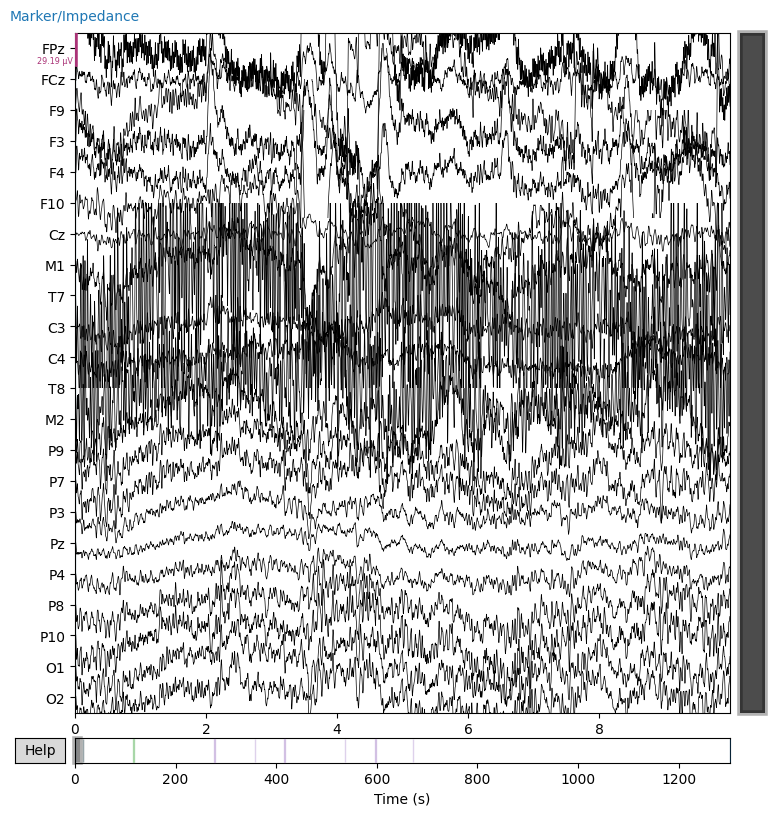

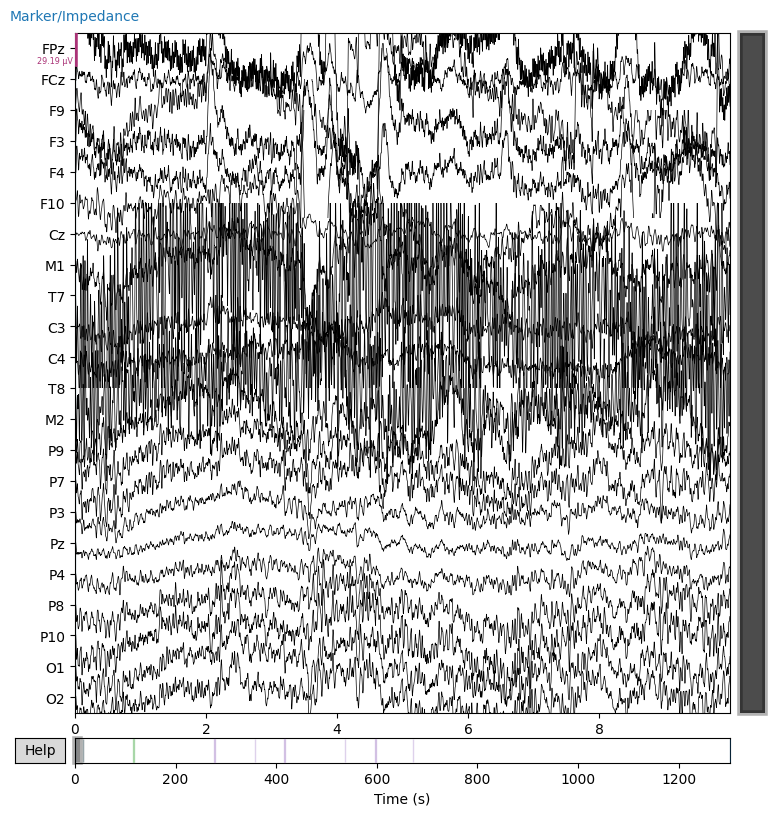

In [118]:
# plot raw data
raw_data.plot(duration=10.0, n_channels=22, scalings='auto', title='Classical Music - Raw Data')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_22972/1153460182.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


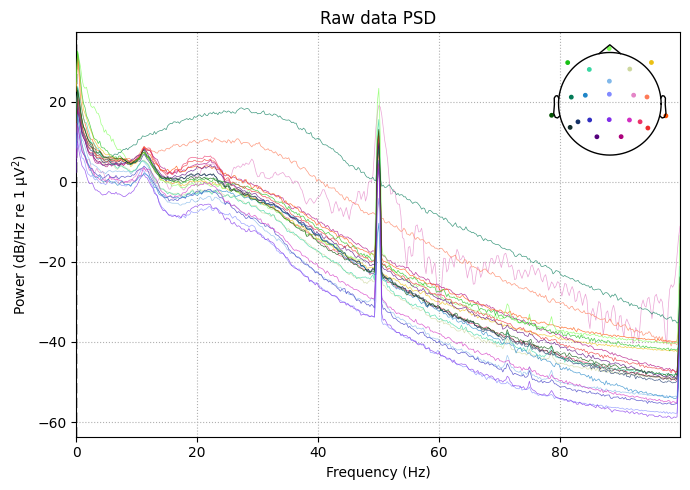

In [119]:
# power spectral density of raw data
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

raw_data.plot_psd(fmax=100, ax=ax, show=False)
ax.set_title('Raw data PSD')

plt.tight_layout()
plt.show()


## 4. Preprocessing Pipeline


### 4.1 Notch Filtering (Remove Line Noise)


In [120]:
# copy for preprocessing
raw_data_filtered = raw_data.copy()

# 50 and 100 Hz notch filters
raw_data_filtered.notch_filter([50, 100])


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

### 4.2 Bandpass Filtering (Keep 1-40 Hz)


In [121]:
# bandpass filter - 1-40 hz
raw_data_filtered.filter(l_freq=1, h_freq=40)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_22972/3007776348.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


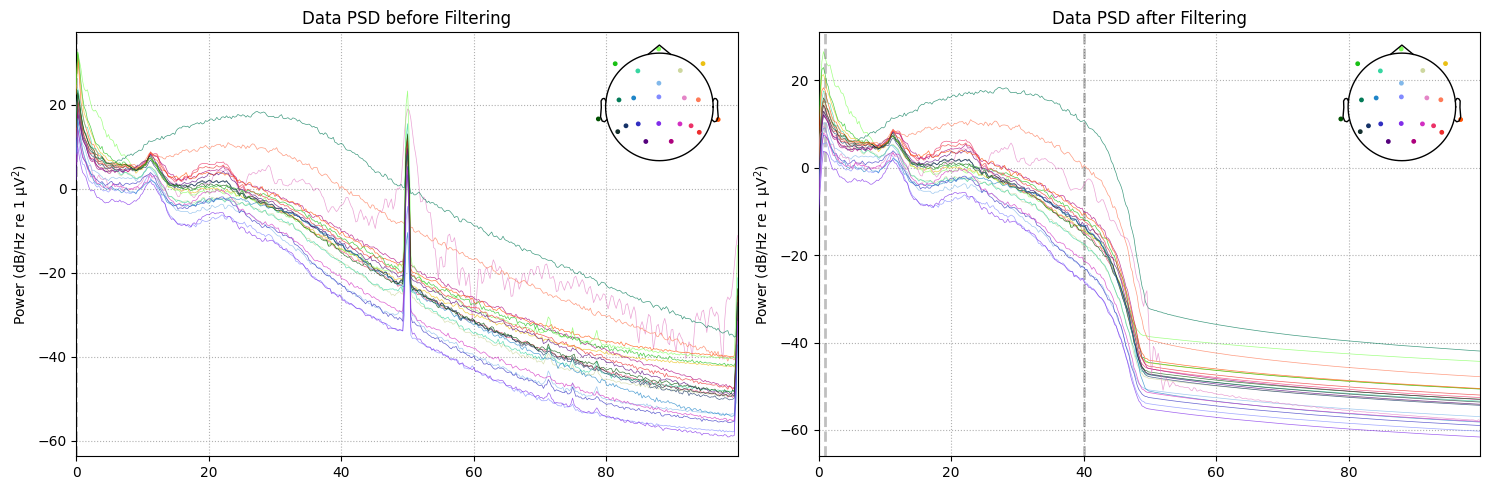

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# data psd before 
raw_data.plot_psd(fmax=100, ax=axes[0], show=False)
axes[0].set_title('Data PSD before Filtering')

# data psd adfter
raw_data_filtered.plot_psd(fmax=100, ax=axes[1], show=False)
axes[1].set_title('Data PSD after Filtering')
plt.tight_layout()
plt.show()


### 4.3 ICA - Independent Component Analysis (Remove Artifacts)


Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.2s.


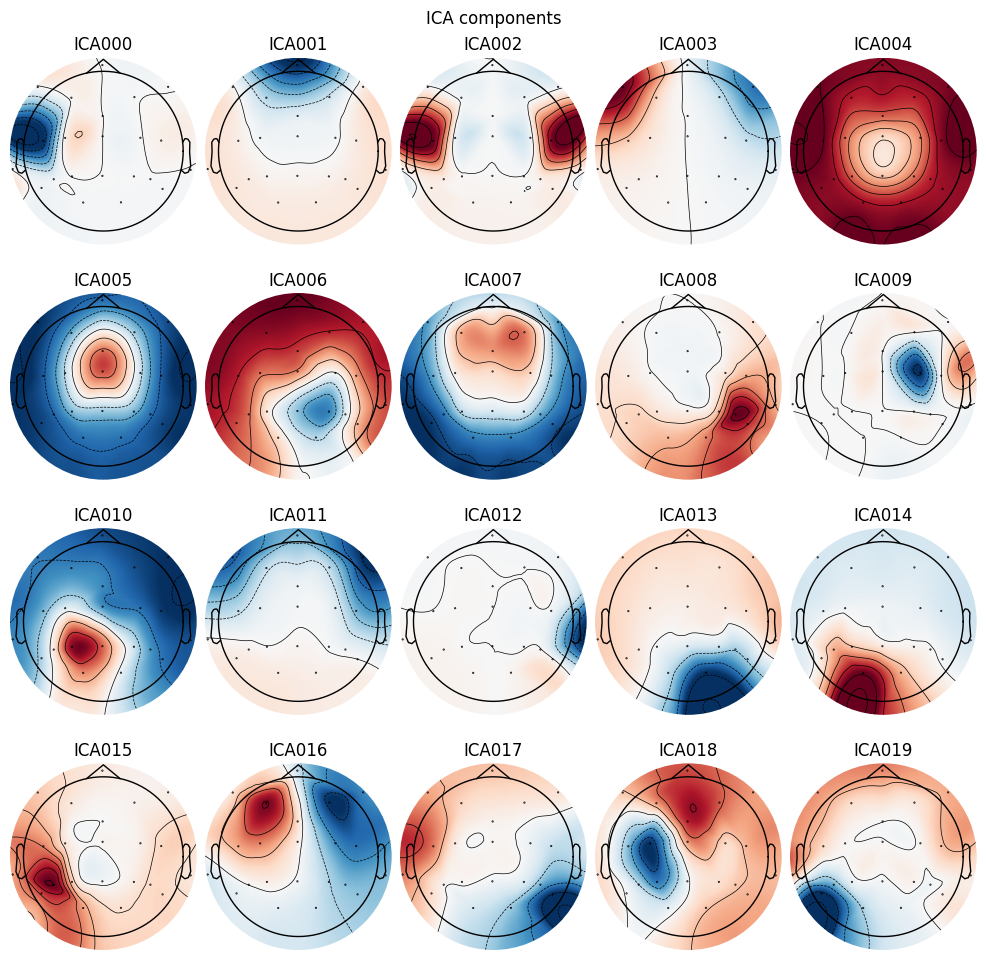

In [123]:
# fit ica on filtered data
ica_data = ICA(n_components=20, random_state=97, max_iter='auto')
ica_data.fit(raw_data_filtered)

# show ica components
fig = ica_data.plot_components()

# TODO: find artifacts to exclude in the next step

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated


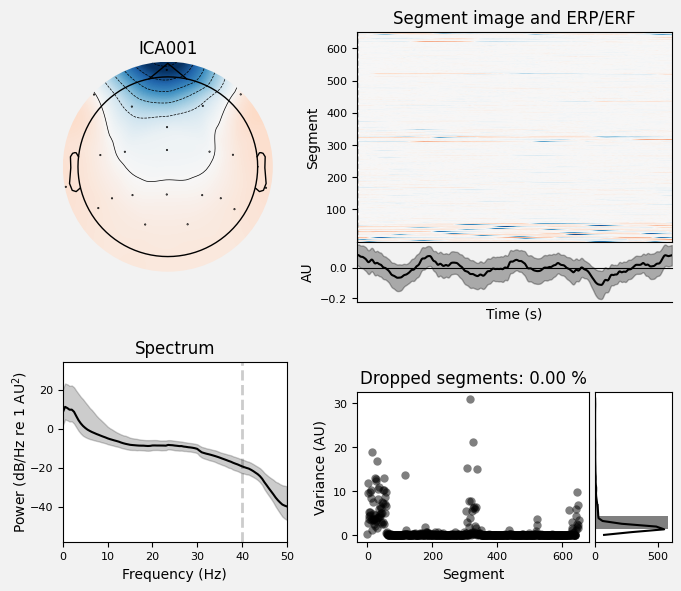

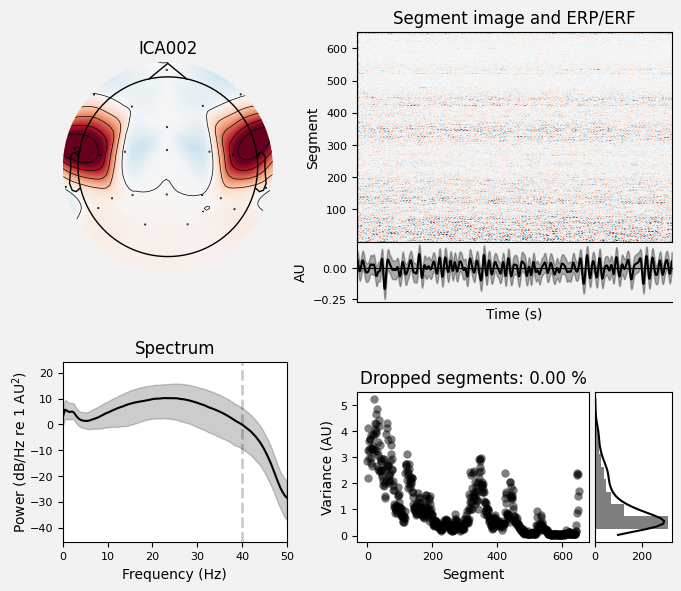

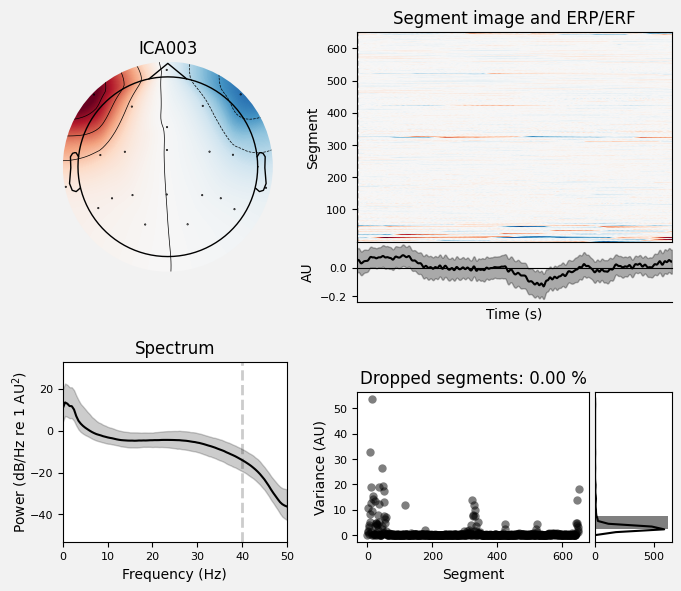

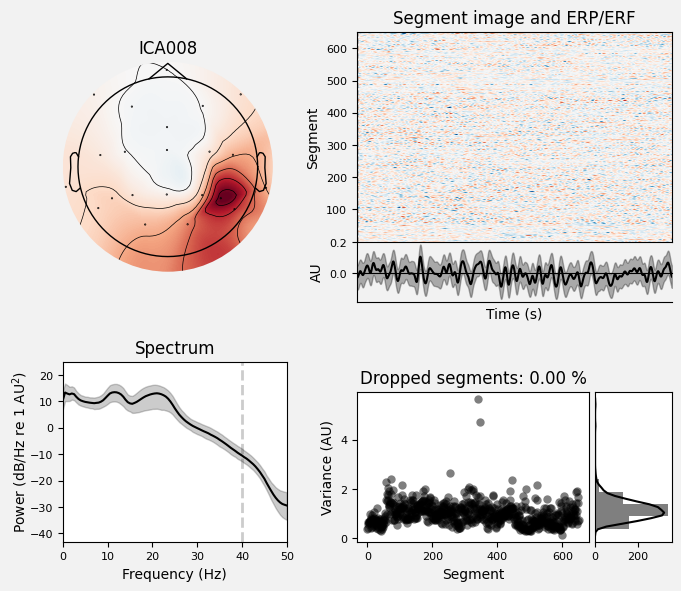

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [124]:
# ICA component properties - helps you find artifacts
# look for
# - activity frontal channels - eye blinks
# - activity temporal channels - muscle artifacts
# - unusual frequency content
ica_data.plot_properties(raw_data_filtered, picks=[1,2,3,8]) # change picks as needed


### 4.4 Apply ICA (Remove Artifacts)

**!!! IMPORTANT !!!** Before running this cell, you should:
1. Inspect the ICA components
2. Identify rtifacts
3. Set `ica.exclude`


In [125]:
ica_data.exclude = [1,2,3,8]  # indexes of excluded components

# apply ICA
raw_data_clean = ica_data.apply(raw_data_filtered.copy())


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 22 PCA components


## 5. Visualize Cleaned Data


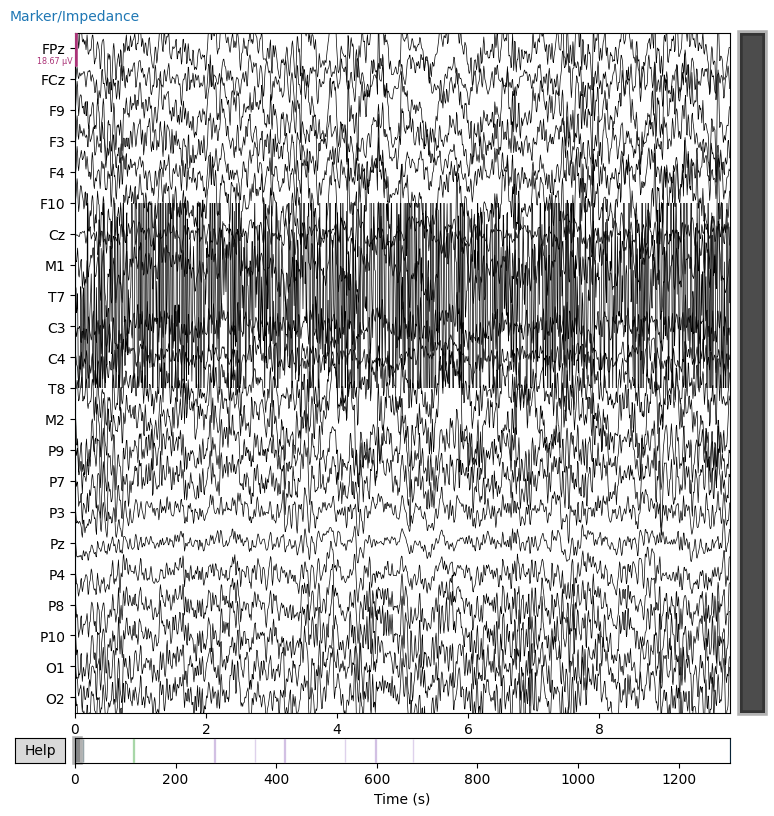

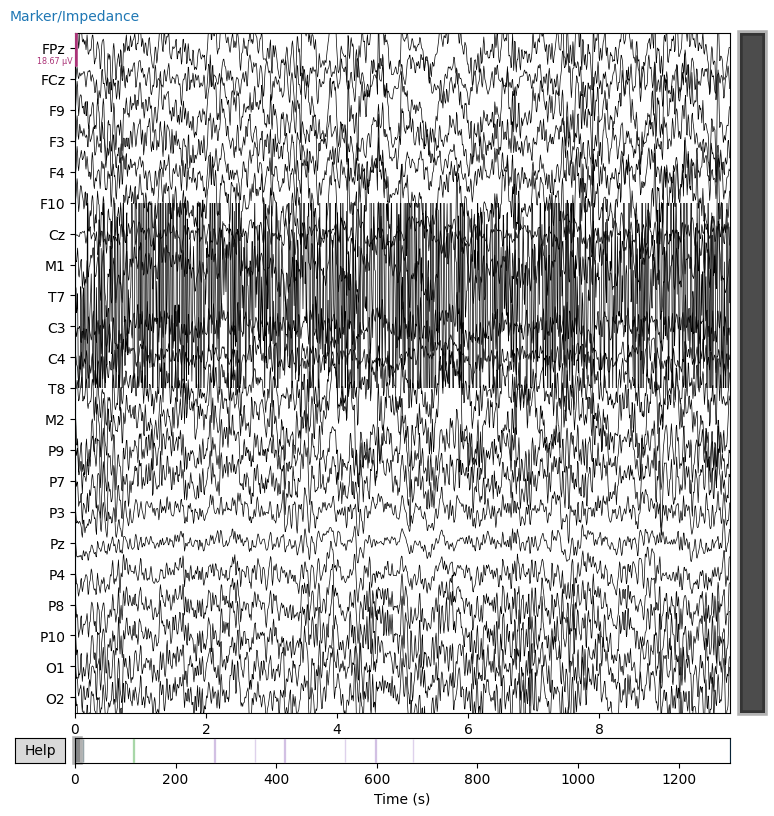

In [126]:
# plot clean data
raw_data_clean.plot(duration=10.0, n_channels=22, scalings='auto', 
                        title='Cleaned Data')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_22972/4164960763.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


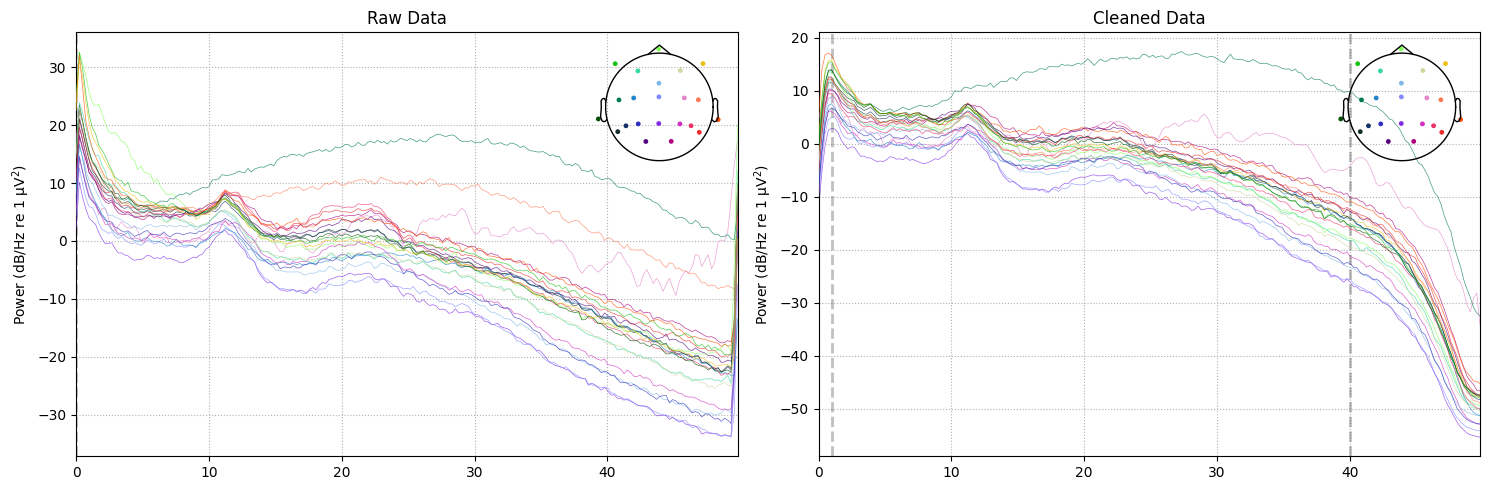

In [127]:
# compare psd before and after cleaning
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# raw
raw_data.plot_psd(fmax=50, ax=axes[0], show=False)
axes[0].set_title('Raw Data')
# clean
raw_data_clean.plot_psd(fmax=50, ax=axes[1], show=False)
axes[1].set_title('Cleaned Data')
plt.tight_layout()
plt.show()


## 6. Epoching

Segment the continuous data into epochs based on experimental protocol phases.
s1000 marks the protocol start, and s1050 markers indicate the end of each phase.


In [128]:
# Extract protocol start and phase end markers
protocol_start = None
phase_ends = []

for i, (onset, duration, description) in enumerate(zip(
    raw_data_clean.annotations.onset,
    raw_data_clean.annotations.duration,
    raw_data_clean.annotations.description
)):
    desc_str = str(description)
    if 's1000' in desc_str:
        protocol_start = onset
        print(f"Protocol start (s1000): {onset:.1f}s")
    elif 's1050' in desc_str:
        phase_ends.append(onset)
        print(f"Phase end (s1050): {onset:.1f}s")

phase_ends.sort()
print(f"\nFound {len(phase_ends)} phase end markers")

if protocol_start is None:
    print("No s1000 marker found. Using first annotation as start.")
    protocol_start = raw_data_clean.annotations.onset[0]

Protocol start (s1000): 116.1s
Phase end (s1050): 276.0s
Phase end (s1050): 357.5s
Phase end (s1050): 416.4s
Phase end (s1050): 536.4s
Phase end (s1050): 596.2s
Phase end (s1050): 671.3s

Found 6 phase end markers


In [129]:
# Define phase boundaries based on actual markers
phase_boundaries = {}

if protocol_start is not None and len(phase_ends) > 0:
    phase_boundaries['phase_1'] = (protocol_start, phase_ends[0])
    
    for i in range(1, len(phase_ends)):
        phase_boundaries[f'phase_{i+1}'] = (phase_ends[i-1], phase_ends[i])
    
    recording_end = raw_data_clean.times[-1]
    phase_boundaries[f'phase_{len(phase_ends)+1}'] = (phase_ends[-1], recording_end)
    
    print(f"\nPhase boundaries:")
    for phase_name, (start, end) in phase_boundaries.items():
        duration = end - start
        print(f"  {phase_name}: {start:.1f}s - {end:.1f}s (duration: {duration:.1f}s = {duration/60:.1f} min)")
else:
    print("Cannot determine phase boundaries without markers")


Phase boundaries:
  phase_1: 116.1s - 276.0s (duration: 159.9s = 2.7 min)
  phase_2: 276.0s - 357.5s (duration: 81.5s = 1.4 min)
  phase_3: 357.5s - 416.4s (duration: 58.9s = 1.0 min)
  phase_4: 416.4s - 536.4s (duration: 120.0s = 2.0 min)
  phase_5: 536.4s - 596.2s (duration: 59.8s = 1.0 min)
  phase_6: 596.2s - 671.3s (duration: 75.0s = 1.3 min)
  phase_7: 671.3s - 1302.0s (duration: 630.8s = 10.5 min)


In [130]:
# Map phase boundaries to your experimental protocol
phase_labels = {
    'phase_1': 'baseline_EO',      # Eyes Open (2 min expected)
    'phase_2': 'baseline_EC',       # Eyes Closed (2 min expected)
    'phase_3': 'task_no_music',     # No music + finger tapping (2 min expected)
    'phase_4': 'break1',            # Break (1 min expected)
    'phase_5': 'task_music',        # Music + finger tapping (2 min expected)
    'phase_6': 'break2',            # Break (1 min expected)
    'phase_7': 'meditation',        # Meditation (10 min expected)
    # 'phase_8': 'post_EC'         # Post-meditation Eyes Closed (if exists, not available in all subjects)
}

# Create labeled phase boundaries
labeled_phases = {}
for phase_num, (start, end) in phase_boundaries.items():
    label = phase_labels.get(phase_num, phase_num)
    labeled_phases[label] = (start, end)
    
print(f"\nLabeled phases:")
for label, (start, end) in labeled_phases.items():
    duration = end - start
    print(f"  {label}: {start:.1f}s - {end:.1f}s ({duration/60:.1f} min)")


Labeled phases:
  baseline_EO: 116.1s - 276.0s (2.7 min)
  baseline_EC: 276.0s - 357.5s (1.4 min)
  task_no_music: 357.5s - 416.4s (1.0 min)
  break1: 416.4s - 536.4s (2.0 min)
  task_music: 536.4s - 596.2s (1.0 min)
  break2: 596.2s - 671.3s (1.3 min)
  meditation: 671.3s - 1302.0s (10.5 min)


In [131]:
# Create epochs for each experimental phase
epoch_duration = 2.0 
epoch_overlap = 0.0   

epochs_by_phase = {}

for phase_name, (abs_start, abs_end) in labeled_phases.items():
    # Check if phase is within recording
    if abs_end > raw_data_clean.times[-1]:
        print(f" {phase_name}: Phase extends beyond recording, adjusting end time")
        abs_end = raw_data_clean.times[-1]
    
    if abs_start < raw_data_clean.times[-1] and abs_end > abs_start:
        try:
            # Crop raw data to this phase
            raw_phase = raw_data_clean.copy().crop(tmin=abs_start, tmax=abs_end)
            
            # Create fixed-length epochs
            epochs_phase = mne.make_fixed_length_epochs(
                raw_phase,
                duration=epoch_duration,
                overlap=epoch_overlap,
                preload=True
            )
            
            epochs_by_phase[phase_name] = epochs_phase
            duration_min = (abs_end - abs_start) / 60
            print(f"✓ {phase_name}: Created {len(epochs_phase)} epochs ({abs_start:.1f}s - {abs_end:.1f}s, {duration_min:.1f} min)")
        except Exception as e:
            print(f" {phase_name}: Error creating epochs - {e}")
    else:
        print(f" {phase_name}: Invalid time range, skipping")

print(f"\n✓ Total phases with epochs: {len(epochs_by_phase)}")

Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 79 events and 1000 original time points ...
0 bad epochs dropped
✓ baseline_EO: Created 79 epochs (116.1s - 276.0s, 2.7 min)
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 1000 original time points ...
0 bad epochs dropped
✓ baseline_EC: Created 40 epochs (276.0s - 357.5s, 1.4 min)
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 1000 original time points ...
0 bad epochs dropped
✓ task_no_music: Created 29 epochs (357.5s - 416.4s, 1.0 min)
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1000 original time points ...
0 bad epochs droppe

In [132]:
# Verify phase durations match expected protocol
expected_durations = {
    'baseline_EO': 120,      
    'baseline_EC': 120,      
    'task_no_music': 120,   
    'break1': 60,          
    'task_music': 120,      
    'break2': 60,          
    'meditation': 600,
    'post_EC': 120          
}

print("\n=== Phase Duration Verification ===")
for phase_name, epochs_phase in epochs_by_phase.items():
    actual_duration = len(epochs_phase) * epoch_duration
    expected = expected_durations.get(phase_name, None)
    
    if expected:
        diff = actual_duration - expected
        print(f"{phase_name}: {actual_duration:.1f}s (expected: {expected}s, diff: {diff:+.1f}s)")
    else:
        print(f"{phase_name}: {actual_duration:.1f}s (no expected duration)")


=== Phase Duration Verification ===
baseline_EO: 158.0s (expected: 120s, diff: +38.0s)
baseline_EC: 80.0s (expected: 120s, diff: -40.0s)
task_no_music: 58.0s (expected: 120s, diff: -62.0s)
break1: 120.0s (expected: 60s, diff: +60.0s)
task_music: 58.0s (expected: 120s, diff: -62.0s)
break2: 74.0s (expected: 60s, diff: +14.0s)
meditation: 630.0s (expected: 600s, diff: +30.0s)


In [133]:
# Create combined epochs with metadata

all_epochs_list = []
all_metadata_list = []

for phase_name, epochs_phase in epochs_by_phase.items():
    n_epochs = len(epochs_phase)
    phase_metadata = pd.DataFrame({
        'phase': [phase_name] * n_epochs,
        'epoch_in_phase': range(n_epochs)
    })
    
    epochs_phase.metadata = phase_metadata
    all_epochs_list.append(epochs_phase)
    all_metadata_list.append(phase_metadata)

# Combine all epochs
if len(all_epochs_list) > 0:
    epochs_all_phases = mne.concatenate_epochs(all_epochs_list)
    epochs_all_phases.metadata = pd.concat(all_metadata_list, ignore_index=True)
    
    print(f"\n✓ Combined epochs: {len(epochs_all_phases)} total epochs")
    print(f"\nEpochs by phase:")
    print(epochs_all_phases.metadata['phase'].value_counts().to_dict())
else:
    print("No epochs created")

Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
589 matching events found
No baseline correction applied
Replacing existing metadata with 2 columns

✓ Combined epochs: 589 total epochs

Epochs by phase:
{'meditation': 315, 'baseline_EO': 79, 'break1': 60, 'baseline_EC': 40, 'break2': 37, 'task_no_music': 29, 'task_music': 29}


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_22972/2818534857.py:19: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_all_phases = mne.concatenate_epochs(all_epochs_list)


In [134]:
# Create summary table of epochs by phase
print("=" * 80)
print("EPOCH SUMMARY TABLE")
print("=" * 80)

summary_data = []
for phase_name, epochs_phase in epochs_by_phase.items():
    n_epochs = len(epochs_phase)
    phase_start = labeled_phases[phase_name][0]
    phase_end = labeled_phases[phase_name][1]
    phase_duration = phase_end - phase_start
    
    summary_data.append({
        'Phase': phase_name,
        'Start (s)': f"{phase_start:.1f}",
        'End (s)': f"{phase_end:.1f}",
        'Duration (s)': f"{phase_duration:.1f}",
        'Duration (min)': f"{phase_duration/60:.2f}",
        'N Epochs': n_epochs,
        'Epoch Duration (s)': f"{epoch_duration:.1f}",
        'Total Epoch Time (s)': f"{n_epochs * epoch_duration:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))
print("\n" + "=" * 80)


EPOCH SUMMARY TABLE

        Phase Start (s) End (s) Duration (s) Duration (min)  N Epochs Epoch Duration (s) Total Epoch Time (s)
  baseline_EO     116.1   276.0        159.9           2.67        79                2.0                158.0
  baseline_EC     276.0   357.5         81.5           1.36        40                2.0                 80.0
task_no_music     357.5   416.4         58.9           0.98        29                2.0                 58.0
       break1     416.4   536.4        120.0           2.00        60                2.0                120.0
   task_music     536.4   596.2         59.8           1.00        29                2.0                 58.0
       break2     596.2   671.3         75.0           1.25        37                2.0                 74.0
   meditation     671.3  1302.0        630.8          10.51       315                2.0                630.0



## 7. Power Analysis (Alpha & Theta) (sample code)

Extract power in alpha (8-13 Hz) and theta (4-8 Hz) frequency bands and compare between conditions.

In [ ]:
# # Compute PSD for epochs
# # Let MNE choose optimal parameters based on epoch length
# psd_data = epochs_data.compute_psd(
#     method='welch',
#     fmin=1.0,
#     fmax=40.0
#     # Don't specify n_fft - MNE will choose appropriate value
# )

Effective window size : 2.502 (s)


Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_22972/2960340058.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


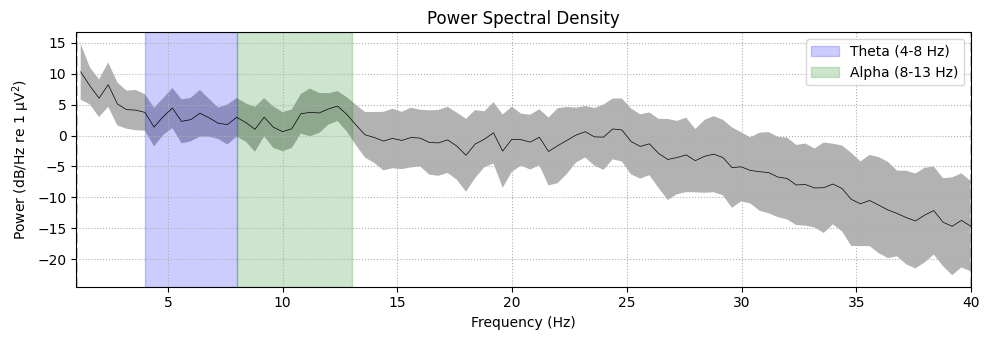

In [ ]:
# # Visualize power spectral density

# psd_data.plot(average=True, show=False, picks='eeg')
# plt.title('Power Spectral Density')
# plt.axvspan(4, 8, alpha=0.2, color='blue', label='Theta (4-8 Hz)')
# plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
# plt.legend()
# plt.xlim(1, 40)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Extract power in specific frequency bands
# # Define frequency bands
# freq_bands = {
#     'theta': (4, 8),   # Theta: 4-8 Hz
#     'alpha': (8, 13),  # Alpha: 8-13 Hz
# }

# # Get PSD data
# psd_data_data = psd_data.get_data()  # Shape: (n_epochs, n_channels, n_freqs)

# freqs_data = psd_data.freqs

# print("Extracting band power...")

# # Function to extract band power
# def extract_band_power(psd_data, freqs, band_name, fmin, fmax):
#     """Extract average power in a frequency band"""
#     freq_mask = (freqs >= fmin) & (freqs <= fmax)
#     band_power = psd_data[:, :, freq_mask].mean(axis=2)  # Average across frequencies
#     return band_power

# # Extract band power for each condition
# band_power_data = {}

# for band_name, (fmin, fmax) in freq_bands.items():
#     band_power_data[band_name] = extract_band_power(
#         psd_data_data, freqs_data, band_name, fmin, fmax
#     )
#     print(f"✓ {band_name.capitalize()} ({fmin}-{fmax} Hz): "
#           f"data shape {band_power_data[band_name].shape}, ")

# print("\n✓ Band power extraction complete")


Extracting band power...
✓ Theta (4-8 Hz): data shape (7, 22), 
✓ Alpha (8-13 Hz): data shape (7, 22), 

✓ Band power extraction complete


In [138]:
# Compute average power across epochs and channels for each band
# print("\n=== Average Band Power (across all epochs and channels) ===")
# for band_name in ['theta', 'alpha']:
#     classical_avg = band_power_classical[band_name].mean()
#     rock_avg = band_power_rock[band_name].mean()
#     diff = rock_avg - classical_avg
#     diff_pct = (diff / classical_avg) * 100
    
#     print(f"\n{band_name.capitalize()} Band ({freq_bands[band_name][0]}-{freq_bands[band_name][1]} Hz):")
#     print(f"  Classical: {classical_avg:.4f} (arbitrary units)")
#     print(f"  Rock:       {rock_avg:.4f} (arbitrary units)")
#     print(f"  Difference: {diff:.4f} ({diff_pct:+.1f}%)")


# TODO: ask harveer why


In [139]:
# # Visualize band power comparison
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# # Theta power comparison
# theta_classical = band_power_classical['theta'].mean(axis=0)  # Average across epochs
# theta_rock = band_power_rock['theta'].mean(axis=0)

# axes[0].bar(range(len(theta_classical)), theta_classical, alpha=0.7, label='Classical', color='blue')
# axes[0].bar(range(len(theta_rock)), theta_rock, alpha=0.7, label='Rock', color='red')
# axes[0].set_xlabel('Channel')
# axes[0].set_ylabel('Power (arbitrary units)')
# axes[0].set_title('Theta Band Power (4-8 Hz) by Channel')
# axes[0].set_xticks(range(len(epochs_classical.ch_names)))
# axes[0].set_xticklabels(epochs_classical.ch_names, rotation=45, ha='right')
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # Alpha power comparison
# alpha_classical = band_power_classical['alpha'].mean(axis=0)  # Average across epochs
# alpha_rock = band_power_rock['alpha'].mean(axis=0)

# axes[1].bar(range(len(alpha_classical)), alpha_classical, alpha=0.7, label='Classical', color='blue')
# axes[1].bar(range(len(alpha_rock)), alpha_rock, alpha=0.7, label='Rock', color='red')
# axes[1].set_xlabel('Channel')
# axes[1].set_ylabel('Power (arbitrary units)')
# axes[1].set_title('Alpha Band Power (8-13 Hz) by Channel')
# axes[1].set_xticks(range(len(epochs_classical.ch_names)))
# axes[1].set_xticklabels(epochs_classical.ch_names, rotation=45, ha='right')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


In [140]:
# # Topographic maps of band power
# # Create average power across epochs for visualization
# theta_classical_avg = band_power_classical['theta'].mean(axis=0)
# alpha_classical_avg = band_power_classical['alpha'].mean(axis=0)
# theta_rock_avg = band_power_rock['theta'].mean(axis=0)
# alpha_rock_avg = band_power_rock['alpha'].mean(axis=0)

# # Create evoked objects for topomap plotting
# # We'll use the average of epochs as a template
# evoked_classical = epochs_classical.average()
# evoked_rock = epochs_rock.average()

# # Create topomaps
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# # Theta - Classical
# mne.viz.plot_topomap(
#     theta_classical_avg, 
#     evoked_classical.info, 
#     axes=axes[0, 0],
#     show=False
# )
# axes[0, 0].set_title('Classical - Theta (4-8 Hz)')

# # Theta - Rock
# mne.viz.plot_topomap(
#     theta_rock_avg,
#     evoked_rock.info,
#     axes=axes[0, 1],
#     show=False
# )
# axes[0, 1].set_title('Rock - Theta (4-8 Hz)')

# # Alpha - Classical
# mne.viz.plot_topomap(
#     alpha_classical_avg,
#     evoked_classical.info,
#     axes=axes[1, 0],
#     show=False
# )
# axes[1, 0].set_title('Classical - Alpha (8-13 Hz)')

# # Alpha - Rock
# mne.viz.plot_topomap(
#     alpha_rock_avg,
#     evoked_rock.info,
#     axes=axes[1, 1],
#     show=False
# )
# axes[1, 1].set_title('Rock - Alpha (8-13 Hz)')

# plt.tight_layout()
# plt.show()

In [141]:
# # Summary statistics by brain region
# # Group channels by brain region
# frontal_channels = ['FPz', 'F9', 'F3', 'F4', 'F10', 'FCz']
# central_channels = ['Cz', 'C3', 'C4']
# temporal_channels = ['T7', 'T8']
# parietal_channels = ['P9', 'P7', 'P3', 'Pz', 'P4', 'P8', 'P10']
# occipital_channels = ['O1', 'O2']

# def get_region_power(band_power, channel_names, region_channels):
#     """Get average power for a brain region"""
#     region_indices = [i for i, ch in enumerate(channel_names) if ch in region_channels]
#     if len(region_indices) == 0:
#         return None
#     return band_power[:, region_indices].mean(axis=1).mean()  # Average across epochs and channels

# print("\n=== Band Power by Brain Region ===")
# regions = {
#     'Frontal': frontal_channels,
#     'Central': central_channels,
#     'Temporal': temporal_channels,
#     'Parietal': parietal_channels,
#     'Occipital': occipital_channels
# }

# for region_name, region_chs in regions.items():
#     print(f"\n{region_name}:")
#     for band_name in ['theta', 'alpha']:
#         classical_power = get_region_power(
#             band_power_classical[band_name], 
#             epochs_classical.ch_names, 
#             region_chs
#         )
#         rock_power = get_region_power(
#             band_power_rock[band_name],
#             epochs_rock.ch_names,
#             region_chs
#         )
#         if classical_power is not None and rock_power is not None:
#             diff_pct = ((rock_power - classical_power) / classical_power) * 100
#             print(f"  {band_name.capitalize()}: Classical={classical_power:.4f}, "
#                   f"Rock={rock_power:.4f} ({diff_pct:+.1f}%)")
